In [179]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import os
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  #<-- Uncomment to disable GPU

In [180]:
# Load the trained model
model = tf.keras.models.load_model(
    'Models/Improved_Models/LSTM_Model.keras'
)

In [181]:
# Load the saved scalers
scaler = joblib.load("Models/Improved_Models/Improved_Models.pkl")

In [182]:
# Load the data
csv_file = 'Data/test_data/ladpho_test.csv'
df = pd.read_csv(csv_file)

In [183]:
print(df.columns.tolist())

['datetimes', 'stn_id', 'temp', 'salinity', 'depth']


In [184]:
df

,datetimes,stn_id,temp,salinity,depth
0,2024-04-15 00:00:00,S6,32.11,7.60,2.54
1,2024-04-15 01:00:00,S6,32.12,8.45,2.46
2,2024-04-15 02:00:00,S6,32.12,9.05,2.30
3,2024-04-15 03:00:00,S6,32.14,9.54,2.12
4,2024-04-15 06:00:00,S6,31.98,9.90,2.19
...,...,...,...,...,...
5785,2024-12-31 17:00:00,S6,27.65,4.95,1.46
5786,2024-12-31 18:00:00,S6,27.43,4.37,1.31
5787,2024-12-31 20:00:00,S6,26.89,3.75,0.67
5788,2024-12-31 21:00:00,S6,26.75,3.42,0.39


In [185]:
df.rename(columns={'date_time': 'datetimes'}, inplace=True)
df.rename(columns={'Salinity': 'salinity'}, inplace=True)
df.rename(columns={'Sensor_Depth': 'depth'}, inplace=True)

In [186]:
# Convert datetimes to datetime format and set as the index
df['datetimes'] = pd.to_datetime(df['datetimes'], format='%Y-%m-%d %H:%M:%S')
df['date_time_copy'] = df['datetimes']
df.set_index('datetimes', inplace=True)

In [187]:
df = df.loc[:, ['salinity', 'depth', 'date_time_copy']]
print(df.columns.tolist())

['salinity', 'depth', 'date_time_copy']


In [188]:
# df = df['2023-01-01':'2023-12-31']

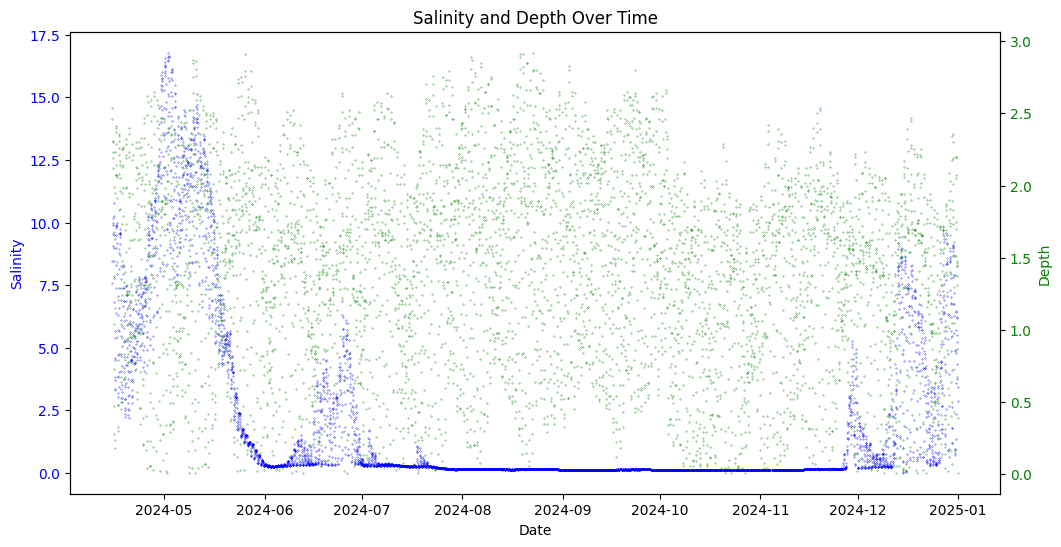

In [189]:
# Plot both columns
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot salinity
ax1.plot(df.index, df['salinity'], '.', markersize=0.5, label='Salinity', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salinity', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot depth (or replace with actual column name for water level if different)
ax2 = ax1.twinx()
ax2.plot(df.index, df['depth'], '.', markersize=0.5, label='Depth', color='g')
ax2.set_ylabel('Depth', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('Salinity and Depth Over Time')
plt.show()

In [190]:
df.columns = ['Salinity', 'wl', 'date_time_copy']

In [191]:
print("Scaler input feature count:", scaler.n_features_in_)

# Optional: Check mean, min, or scale for sanity
print("Scaler feature means or mins:\n", getattr(scaler, 'data_min_', getattr(scaler, 'mean_', 'unknown')))

Scaler input feature count: 2
Scaler feature means or mins:
 [ 0.1  -1.38]


In [192]:
date_time = df.pop('date_time_copy')  # original datetime column
timestamp_s = date_time.map(pd.Timestamp.timestamp)  # seconds since epoch

# Daily cycle
day = 24.0 * 60 * 60
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

# Monthly cycle
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

# Extract year from datetime index
df['year'] = df.index.year

# Encode year cyclically (1-year cycle)
df['year_sin'] = np.sin(2 * np.pi * df['year'] % 1)
df['year_cos'] = np.cos(2 * np.pi * df['year'] % 1) 

# Proper cyclical encoding
df['fractional_year'] = df.index.year + (df.index.dayofyear - 1) / 365.0
df['year_sin'] = np.sin(2 * np.pi * (df['fractional_year'] % 1))  # Use % 1 to get cyclic value
df['year_cos'] = np.cos(2 * np.pi * (df['fractional_year'] % 1))

# Optional: drop helper column
df.drop(columns=['fractional_year'], inplace=True)

In [193]:
print("Model expects input shape:", model.input_shape)

Model expects input shape: (None, 168, 8)


In [194]:
model.summary()

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_75 (Conv1D)              │ (None, 168, 64)        │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_55             │ (None, 168, 64)        │         4,160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_56             │ (None, 168, 64)        │         4,160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_117 (LSTM)                 │ (None, 168, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_118 (LSTM)                 │ (None, 168, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_119 (LSTM)                 │ (None, 168, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 168, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_57             │ (None, 168, 2)         │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,242,248 (4.74 MB)

 Trainable params: 414,082 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 828,166 (3.16 MB)

In [195]:
df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Salinity', 'wl', 'Day sin', 'Day cos', 'month_sin', 'month_cos',
       'year', 'year_sin', 'year_cos'],
      dtype='object')>

In [196]:
df.drop(columns=['year'], inplace=True)

In [197]:
window_size = 168
feature_cols = df.columns.to_list()
scaled_cols = ['Salinity', 'wl']
unscaled_cols = [col for col in feature_cols if col not in scaled_cols]
target_col_index = [0, 1]

input_windows = []
true_vals = []

for i in range(len(df) - 2 * window_size):
    input_window = df[feature_cols].iloc[i : i + window_size].copy()
    label_seq = df[['Salinity', 'wl']].iloc[i + window_size : i + 2 * window_size].copy()

    if label_seq.isnull().values.any() or input_window.isnull().values.any():
        continue

    scaled_input = scaler.transform(input_window[scaled_cols])
    unscaled_input = input_window[unscaled_cols].values
    combined_input = np.hstack([scaled_input, unscaled_input])

    input_windows.append(combined_input)
    true_vals.append(label_seq.values)

input_windows = np.array(input_windows, dtype=np.float32)
true_vals = np.array(true_vals)

# Predict in batch
start = time.time()
pred_scaled = model.predict(input_windows, batch_size=64, verbose=1)
end = time.time()
print(f"Predicted {len(pred_scaled)} samples in {end - start:.2f} seconds")

# Inverse transform predictions
N, T, F = pred_scaled.shape
pred_scaled_flat = pred_scaled.reshape(-1, F)
preds_unscaled_flat = scaler.inverse_transform(pred_scaled_flat)
preds = preds_unscaled_flat.reshape(N, T, F)

75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step
Predicted 4786 samples in 11.38 seconds


In [198]:
input_windows.shape  # (samples, 168, 8) ✅

(4786, 168, 8)

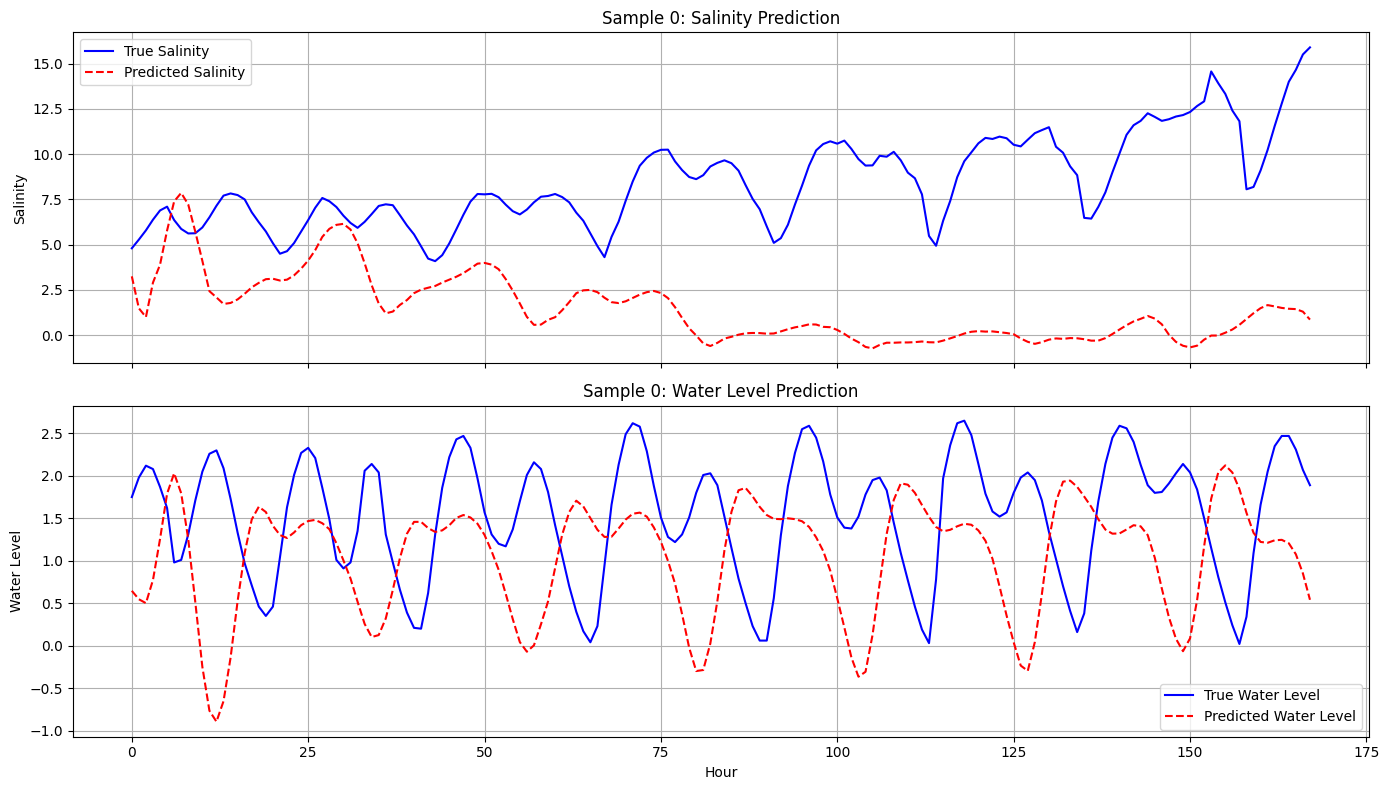

In [ ]:
###### Only one sample of week. other week might look better######

# -- 1. Plot one sample (one predicted week) --
sample_idx = 0  # change this to see other samples

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Salinity
axes[0].plot(true_vals[sample_idx, :, 0], label='True Salinity', color='blue')
axes[0].plot(preds[sample_idx, :, 0], label='Predicted Salinity', linestyle='--', color='red')
axes[0].set_title(f'Sample {sample_idx}: Salinity Prediction')
axes[0].set_ylabel('Salinity')
axes[0].legend()
axes[0].grid(True)

# Water Level
axes[1].plot(true_vals[sample_idx, :, 1], label='True Water Level', color='blue')
axes[1].plot(preds[sample_idx, :, 1], label='Predicted Water Level', linestyle='--', color='red')
axes[1].set_title(f'Sample {sample_idx}: Water Level Prediction')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Water Level')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [208]:
nan_count_per_sample = np.isnan(true_vals[:, :, 0]).sum(axis=1)
print("Samples with NaNs:", (nan_count_per_sample > 0).sum(), "out of", true_vals.shape[0])

Samples with NaNs: 0 out of 4786


In [206]:
print("NaN count in true salinity:", np.isnan(true_vals[:, :, 0]).sum())
print("NaN count in predicted salinity:", np.isnan(preds[:, :, 0]).sum())
print("NaN count in true water level:", np.isnan(true_vals[:, :, 1]).sum())
print("NaN count in predicted water level:", np.isnan(preds[:, :, 1]).sum())

NaN count in true salinity: 0
NaN count in predicted salinity: 0
NaN count in true water level: 0
NaN count in predicted water level: 0


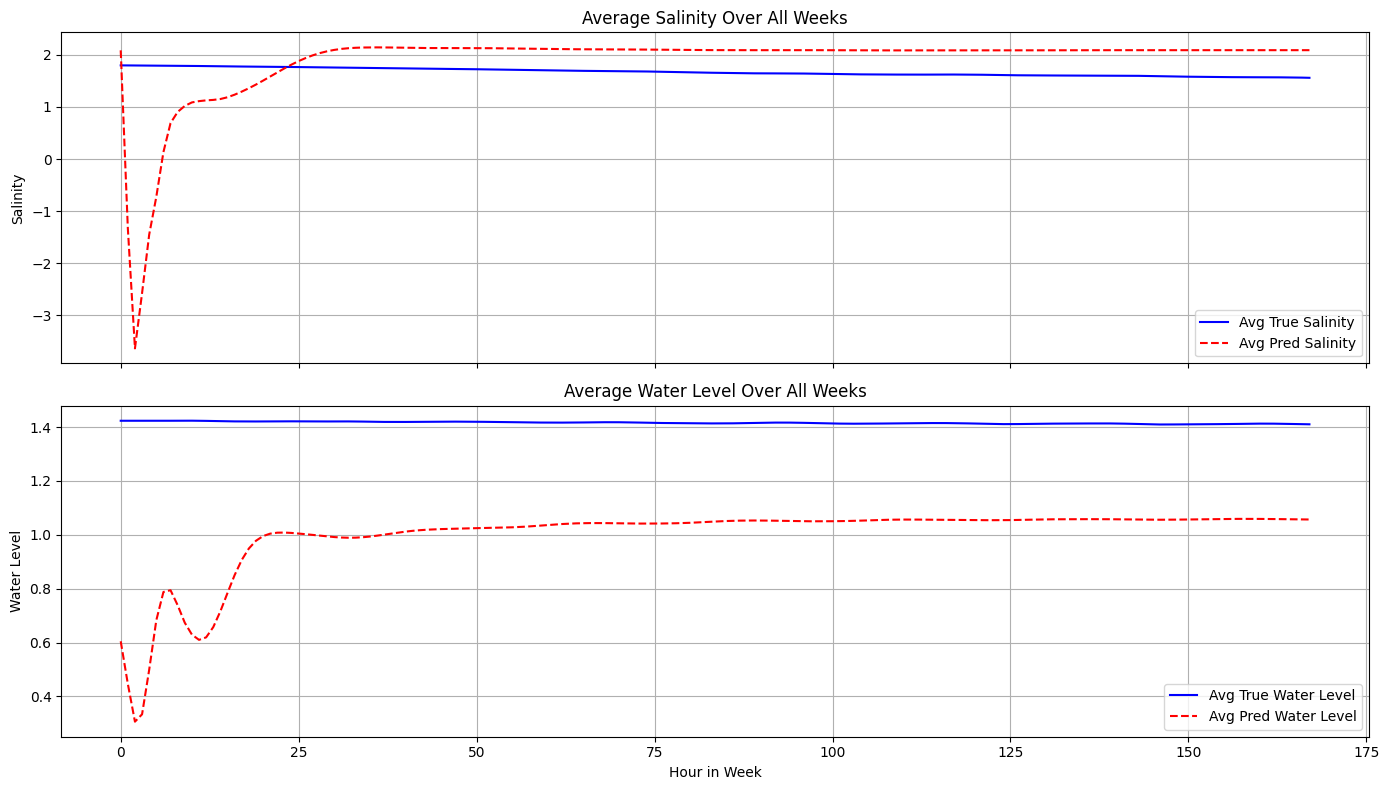

In [202]:
# -- 2. Average prediction across all samples (timesteps vs average value) --
mean_true_sal = np.nanmean(true_vals[:, :, 0], axis=0)
mean_pred_sal = preds[:, :, 0].mean(axis=0)

mean_true_wl = np.nanmean(true_vals[:, :, 1], axis=0)
mean_pred_wl = preds[:, :, 1].mean(axis=0)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(mean_true_sal, label='Avg True Salinity', color='blue')
axes[0].plot(mean_pred_sal, label='Avg Pred Salinity', linestyle='--', color='red')
axes[0].set_title('Average Salinity Over All Weeks')
axes[0].set_ylabel('Salinity')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(mean_true_wl, label='Avg True Water Level', color='blue')
axes[1].plot(mean_pred_wl, label='Avg Pred Water Level', linestyle='--', color='red')
axes[1].set_title('Average Water Level Over All Weeks')
axes[1].set_xlabel('Hour in Week')
axes[1].set_ylabel('Water Level')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

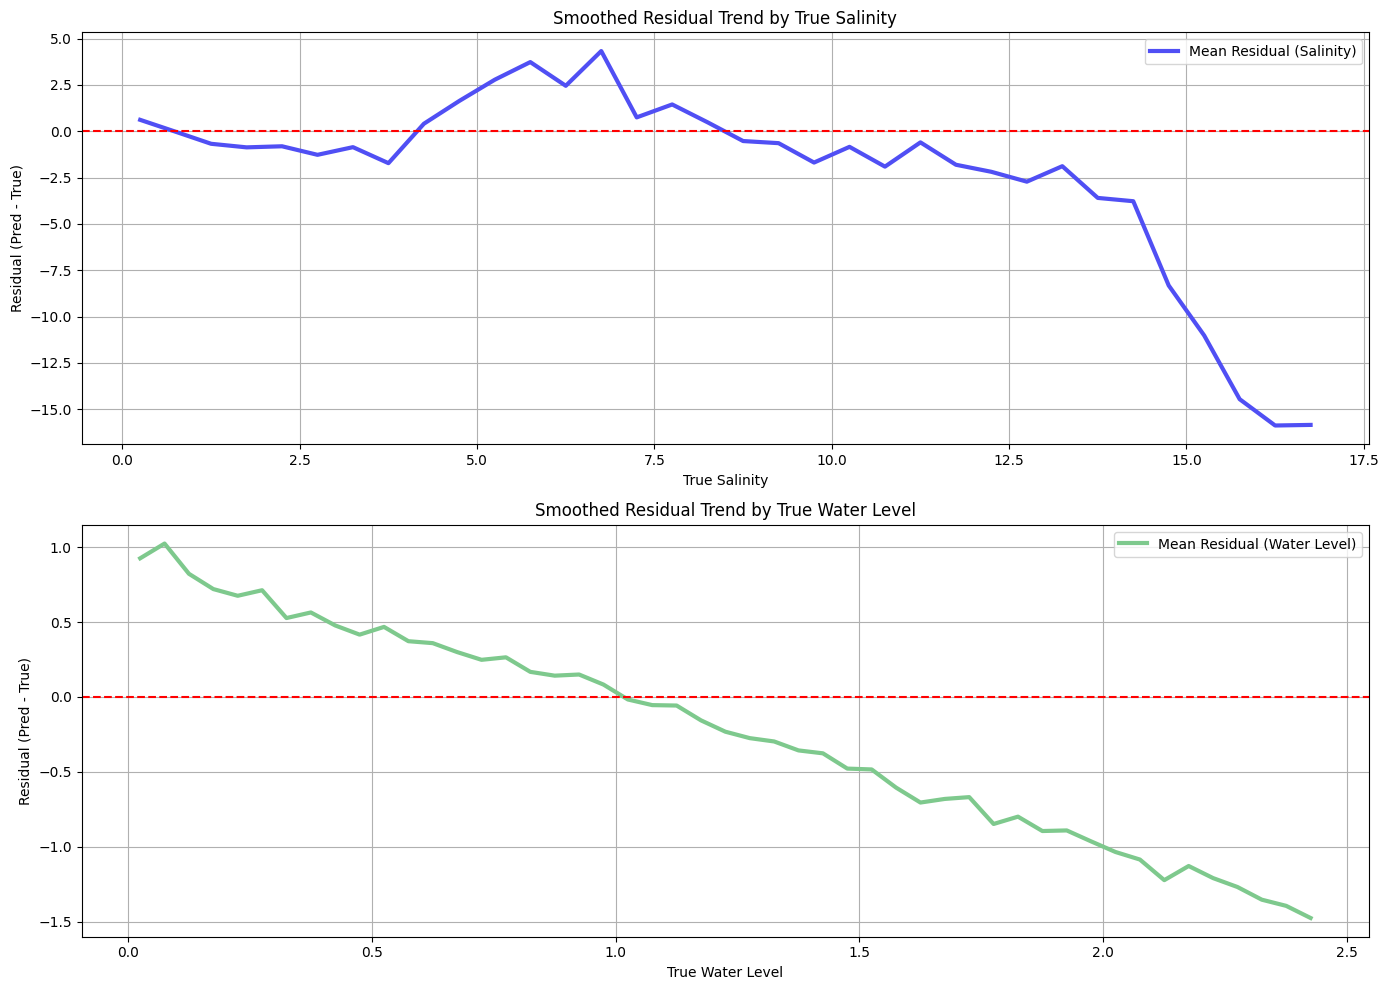

In [203]:
# Flatten and drop NaNs
true_sal = true_vals[:, :, 0].flatten()
res_sal = preds[:, :, 0].flatten() - true_sal

true_wl = true_vals[:, :, 1].flatten()
res_wl = preds[:, :, 1].flatten() - true_wl

# Create dataframes and clean
df_sal = pd.DataFrame({'true': true_sal, 'residual': res_sal}).dropna()
df_wl = pd.DataFrame({'true': true_wl, 'residual': res_wl}).dropna()

# Bin values
df_sal['bin'] = pd.cut(df_sal['true'], bins=np.arange(0, 18, 0.5))
df_wl['bin'] = pd.cut(df_wl['true'], bins=np.arange(0, 2.5, 0.05))

mean_sal = df_sal.groupby('bin', observed=True)['residual'].mean()
mean_wl = df_wl.groupby('bin', observed=True)['residual'].mean()

centers_sal = [interval.mid for interval in mean_sal.index]
centers_wl = [interval.mid for interval in mean_wl.index]

# Plot both trends
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Salinity
axes[0].plot(centers_sal, mean_sal.values, label='Mean Residual (Salinity)', color='#504ff4', linewidth=3)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title("Smoothed Residual Trend by True Salinity")
axes[0].set_xlabel("True Salinity")
axes[0].set_ylabel("Residual (Pred - True)")
axes[0].grid(True)
axes[0].legend()

# Water Level
axes[1].plot(centers_wl, mean_wl.values, label='Mean Residual (Water Level)', color='#7ec98d', linewidth=3)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title("Smoothed Residual Trend by True Water Level")
axes[1].set_xlabel("True Water Level")
axes[1].set_ylabel("Residual (Pred - True)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()